# **Introduction to Unsupervised Machine Learning**

## **1. Unsupervised Machine Learning**

**Common unsupervised machine learning types:**

- Clustering: the process of segmenting the dataset into groups based on the patterns found in the data. Used to segment customers and products, for example.
 - Association: the goal is to find patterns between the variables, not the entries. It's frequently used for market basket analysis, for instance.
- Anomaly detection: this kind of algorithm tries to identify when a particular data point is completely off the rest of the dataset pattern. Frequently used for fraud detection.

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



In [32]:
customers=pd.read_csv("mall_customers.csv")
customers

,CustomerID,Gender,Age,Annual Income,Spending Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


###  **Initialize Centroids**

In [33]:
customers=customers[["Age","Spending Score"]].copy()
centroids=customers.sample(2)
centroids

def fetch_coordinates(centroids):
    return (centroids.iat[0,0],centroids.iat[0,1],centroids.iat[1,0],centroids.iat[1,1])

age_centroid_1, score_centroid_1, age_centroid_2, score_centroid_2=fetch_coordinates(centroids)

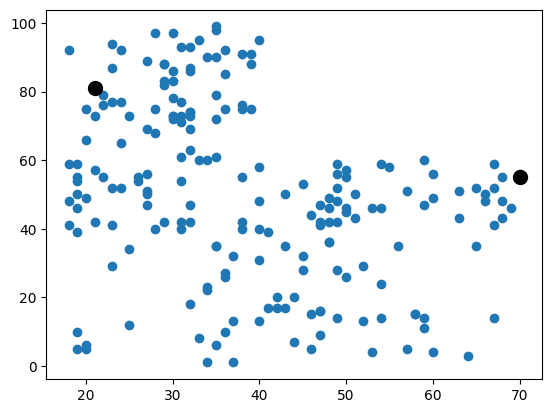

In [34]:
plt.scatter(customers['Age'], customers['Spending Score'])
plt.scatter(centroids['Age'], centroids['Spending Score'], color='black', s=100)
plt.show()

### **Distances Between the Points**

In [35]:
def calculate_distance(row,x,y):
    distance = np.sqrt((row['Age'] - x)**2 + (row['Spending Score'] - y)**2)    
    return distance

list1=[]
list2=[]

for index,row in customers.iterrows():
    dist1=calculate_distance(row,age_centroid_1,score_centroid_1)
    list1.append(dist1)
    dist2=calculate_distance(row,age_centroid_2,score_centroid_2)
    list2.append(dist2)



customers["dist_centroid_1"]=list1
customers["dist_centroid_2"]=list2
customers

,Age,Spending Score,dist_centroid_1,dist_centroid_2
0,19,39,53.450912,42.047592
1,21,81,55.470713,0.000000
2,20,6,70.007142,75.006666
3,23,77,51.894123,4.472136
4,31,40,41.785165,42.201896
...,...,...,...,...
195,35,79,42.438190,14.142136
196,45,28,36.796739,58.180753
197,32,74,42.485292,13.038405
198,32,18,53.037722,63.953108


### **Assigning Clusters**

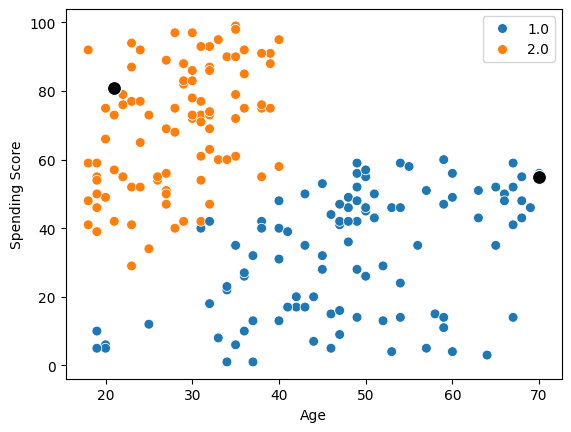

,Age,Spending Score,dist_centroid_1,dist_centroid_2,cluster
0,19,39,53.450912,42.047592,2.0
1,21,81,55.470713,0.000000,2.0
2,20,6,70.007142,75.006666,1.0
3,23,77,51.894123,4.472136,2.0
4,31,40,41.785165,42.201896,1.0
...,...,...,...,...,...
195,35,79,42.438190,14.142136,2.0
196,45,28,36.796739,58.180753,1.0
197,32,74,42.485292,13.038405,2.0
198,32,18,53.037722,63.953108,1.0


In [36]:
def calculate_distance_assign_clusters(customers,centroids):
 
    age_centroid_1, score_centroid_1, age_centroid_2, score_centroid_2=fetch_coordinates(centroids)

    for index,row in customers.iterrows():
        dist1=calculate_distance(row,age_centroid_1,score_centroid_1)
        dist2=calculate_distance(row,age_centroid_2,score_centroid_2)
        if dist1 > dist2 :
            customers.at[index, 'cluster'] = 2
        else:
             customers.at[index, 'cluster'] = 1

    return customers


customers=calculate_distance_assign_clusters(customers,centroids)


sns.scatterplot(x='Age', y='Spending Score', hue='cluster', palette='tab10', data=customers, s=50)
sns.scatterplot(x='Age', y='Spending Score', color='black', data=centroids, s=100)
plt.show()
customers


### **Creating New Clusters**

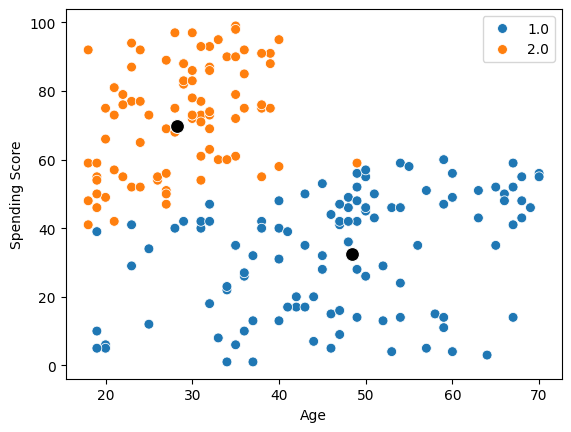

In [37]:
new_centroids=customers.groupby(customers["cluster"]).mean()
new_centroids.reset_index()
#new_centroids=new_centroids.drop("cluster",axis=1)
new_centroids

customers = calculate_distance_assign_clusters(customers, new_centroids)

sns.scatterplot(x='Age', y='Spending Score', hue='cluster', palette='tab10', data=customers, s=50)
sns.scatterplot(x='Age', y='Spending Score', color='black', data=new_centroids, s=100)
plt.show()

### **Wrapping in a Function**

In [38]:
cols_to_keep = ['Age', 'Spending Score']

customers = customers[cols_to_keep].copy()

#Function to create the cluster with one iteration
def create_clusters(customers):
    centroids = customers.sample(2)#Lo idea sería tenerlo fuera y así por llamar muchas veces a esta funcion
    customers = calculate_distance_assign_clusters(customers, centroids)
    new_centroids = customers.groupby('cluster').mean().reset_index()
    new_centroids.drop('cluster', axis=1, inplace=True)
    customers = calculate_distance_assign_clusters(customers, new_centroids)
    return customers['cluster']


clusters = create_clusters(customers)
clusters

0      1.0
1      1.0
2      2.0
3      1.0
4      1.0
      ... 
195    1.0
196    2.0
197    1.0
198    2.0
199    1.0
Name: cluster, Length: 200, dtype: float64

# **2. Iterative K-means algorithm**

In [39]:
customers= pd.read_csv("mall_customers.csv")
customers=customers[["Annual Income","Spending Score"]]

### **Initialize K Centroids**

In [40]:
def get_centroids(customers,k):
    centroids = customers.sample(k)
    return centroids, centroids.values.tolist()

centroids, coords = get_centroids(customers, 2)
centroids, coords

(     Annual Income  Spending Score
 118             67              43
 192            113               8,
 [[67, 43], [113, 8]])

### **Calculating Distances**

In [41]:
def calculate_distance(df, centroids_coords):
    names = []
    for i, centroid in enumerate(centroids_coords):
        name = f'dist_centroid_{i + 1}'
        df[name] = np.sqrt((df.iloc[:,0] - centroid[0])**2 + (df.iloc[:,1] - centroid[1])**2)
        names.append(name)
    
    return df, names


customers, dist_names = calculate_distance(customers, coords)
dist_names

['dist_centroid_1', 'dist_centroid_2']

### **Assigning Clusters**

<Axes: xlabel='Annual Income', ylabel='Spending Score'>

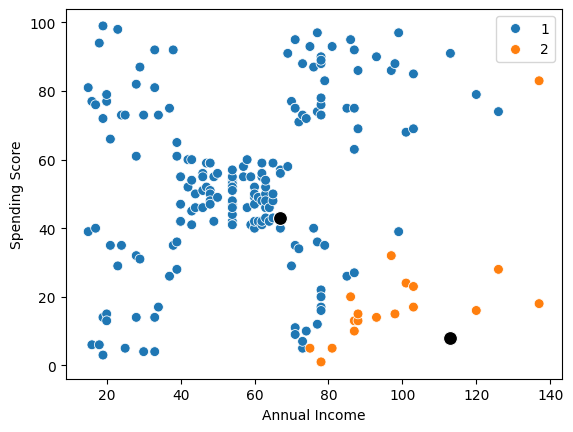

In [42]:
customers['cluster'] = customers[dist_names].idxmin(axis=1).str.split('_').str[-1]

sns.scatterplot(x='Annual Income', y='Spending Score', hue='cluster', palette='tab10', data=customers, s=50)
sns.scatterplot(x='Annual Income', y='Spending Score', color='black', data=centroids, s=100)

### **Recalculating Centroids**

In [43]:
variables = customers.columns[:2]
new_centroids = round(customers.groupby('cluster')[variables].mean(), 4)
new_coords = new_centroids.values.tolist()

new_coords

[[56.3111, 53.7722], [98.8, 18.05]]

### **Creating an Iterative Process**

Total Iterations: 15


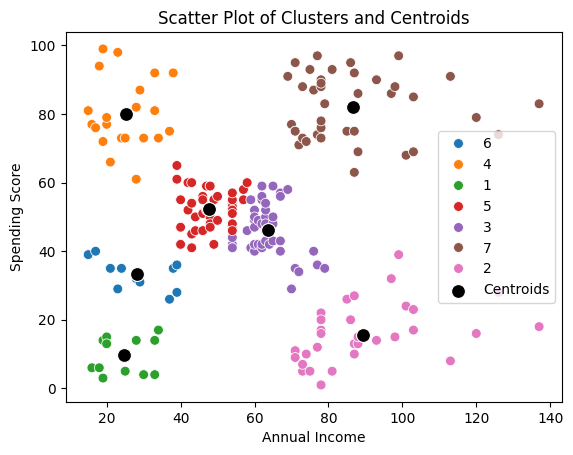

In [44]:
customers = pd.read_csv('mall_customers.csv')

def k_means(customers,k,n=100):
    
    cols_to_keep = ['Annual Income', 'Spending Score']

    customers = customers[cols_to_keep].copy()

    variables = customers.columns

    centroids, coords = get_centroids(customers, k)


    for i in range(n): 

        last_coords=coords.copy()
        customers, dist_names = calculate_distance(customers, coords)

        customers['cluster'] = customers[dist_names].idxmin(axis=1).str.split('_').str[-1]

        centroids = round(customers.groupby('cluster')[variables].mean(), 4)
        
        coords = centroids.values.tolist()

        if coords == last_coords:
            break

    print(f'Total Iterations: {i + 1}')
                        
    # Asegúrate de que 'data' solo se usa una vez en cada llamada de scatterplot
    sns.scatterplot(x='Annual Income', y='Spending Score', hue='cluster', palette='tab10', data=customers, s=50)
    sns.scatterplot(x='Annual Income', y='Spending Score', color='black', s=100, label='Centroids', data=centroids)

    plt.xlabel("Annual Income")
    plt.ylabel("Spending Score")
    plt.title("Scatter Plot of Clusters and Centroids")
    plt.legend()
    plt.show()

    return customers["cluster"]

clusters=k_means(customers,7,n=100)

# **3. Number of Clusters and the Elbow Rule**

## **Inertia**

Total Iterations: 4


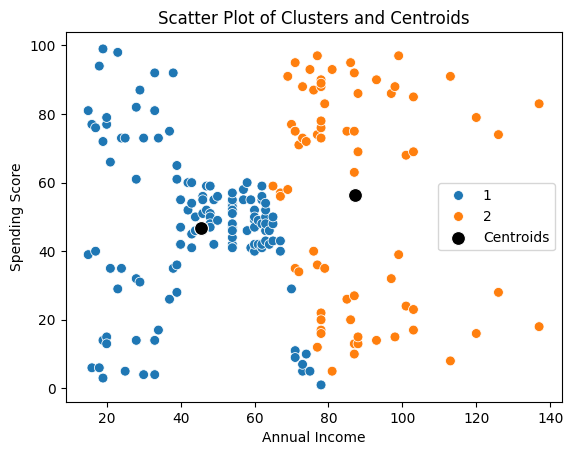

In [45]:
customers = pd.read_csv('mall_customers.csv')

def k_means(customers,k,n=100):
    
    cols_to_keep = ['Annual Income', 'Spending Score']

    customers = customers[cols_to_keep].copy()

    variables = customers.columns

    centroids, coords = get_centroids(customers, k)


    for i in range(n): 

        last_coords=coords.copy()
        customers, dist_names = calculate_distance(customers, coords)

        customers['cluster'] = customers[dist_names].idxmin(axis=1).str.split('_').str[-1]

        centroids = round(customers.groupby('cluster')[variables].mean(), 4)
        
        coords = centroids.values.tolist()

        if coords == last_coords:
            break

    print(f'Total Iterations: {i + 1}')

    customers['sqrt_dist_centroid'] = customers[dist_names].min(axis=1)**2
    inertia = customers['sqrt_dist_centroid'].sum()


    # Asegúrate de que 'data' solo se usa una vez en cada llamada de scatterplot
    sns.scatterplot(x='Annual Income', y='Spending Score', hue='cluster', palette='tab10', data=customers, s=50)
    sns.scatterplot(x='Annual Income', y='Spending Score', color='black', s=100, label='Centroids', data=centroids)

    plt.xlabel("Annual Income")
    plt.ylabel("Spending Score")
    plt.title("Scatter Plot of Clusters and Centroids")
    plt.legend()
    plt.show()


    return customers["cluster"],inertia

clusters,inertia=k_means(customers,2,n=100)

In [46]:
inertia

np.float64(185140.01649344)

## **Calculating More Inertias**

Total Iterations: 2


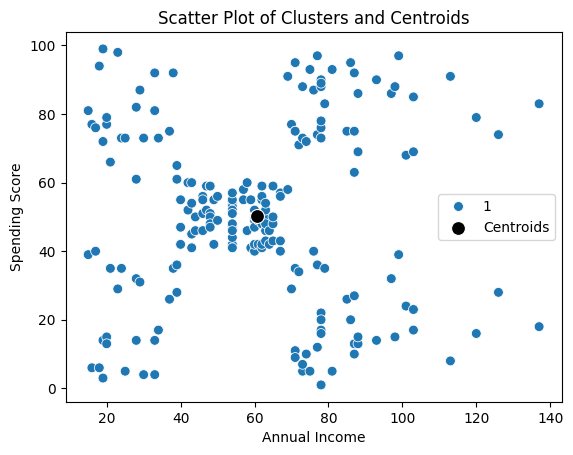

Total Iterations: 7


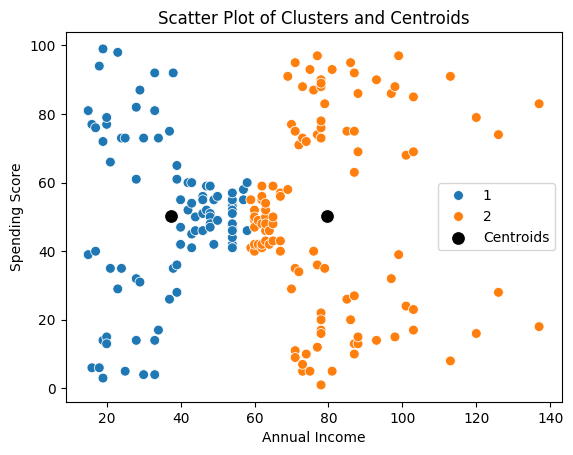

Total Iterations: 5


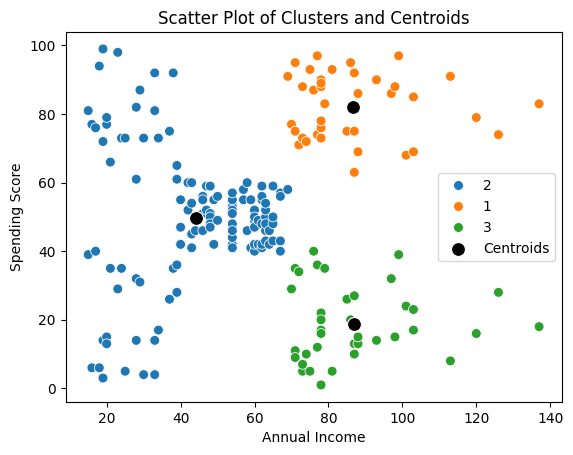

Total Iterations: 7


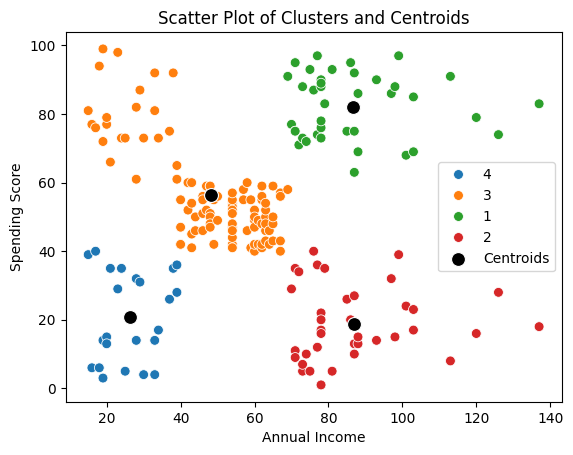

Total Iterations: 8


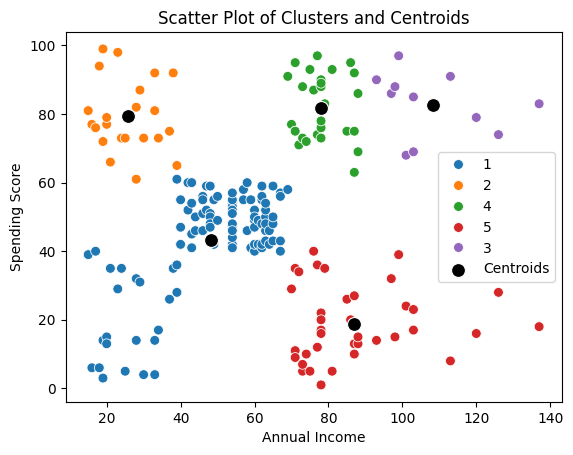

Total Iterations: 8


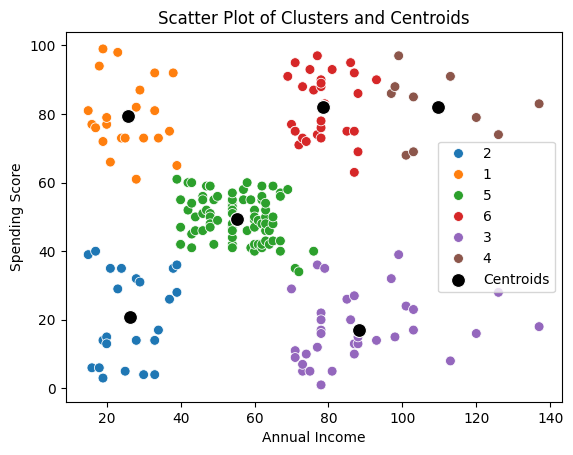

Total Iterations: 6


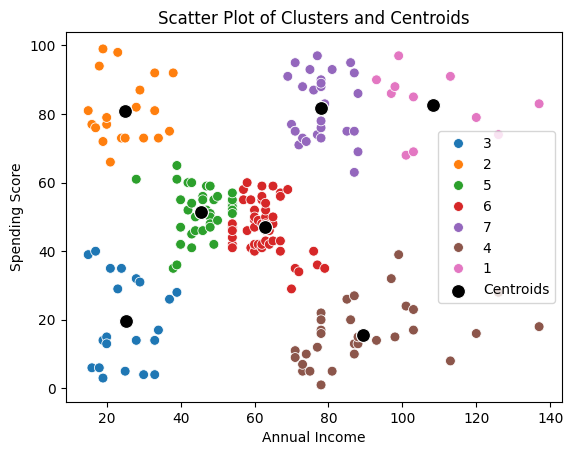

Total Iterations: 4


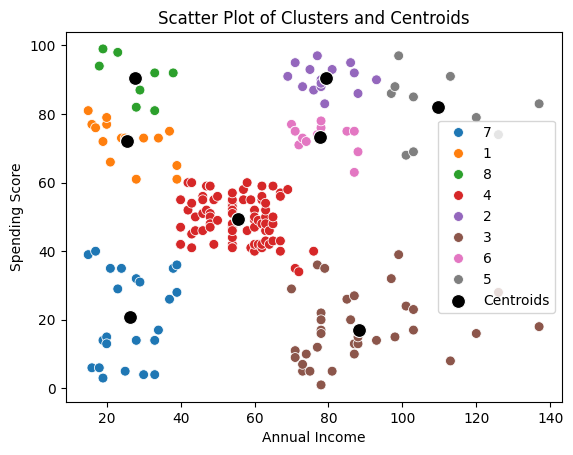

Total Iterations: 6


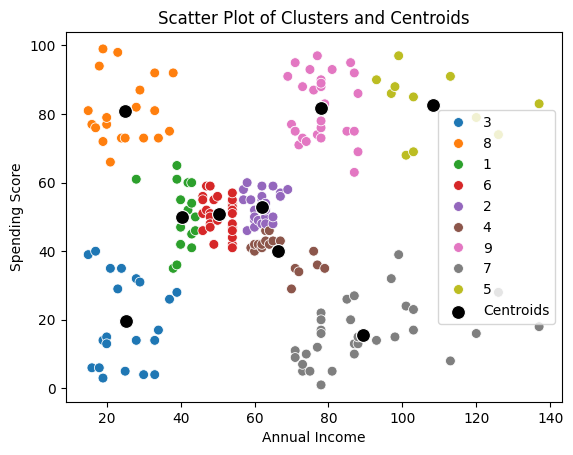

Total Iterations: 100


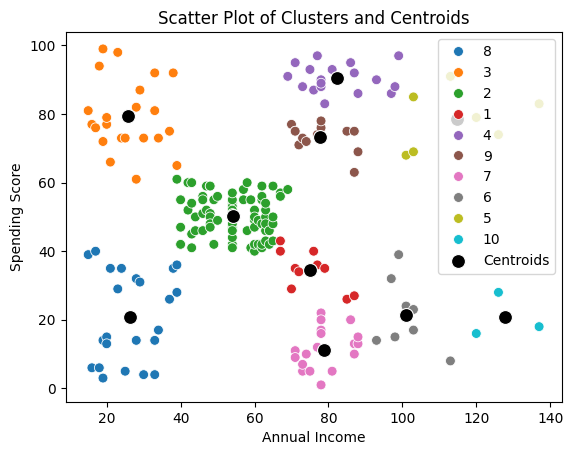

[np.float64(269981.27999999997), np.float64(181363.5959597), np.float64(106348.37306241), np.float64(73679.78903966), np.float64(66698.05471970001), np.float64(37233.81451091), np.float64(31676.369732409996), np.float64(33363.652795190006), np.float64(28682.666042749996), np.float64(23773.03526474)]


In [47]:
inertias = []
for k in range(1,11):
    clusters, inertia = k_means(customers, k=k)
    inertias.append(inertia)
    
print(inertias)

## **The Elbow Curve**

In [48]:
import matplotlib.pyplot as plt

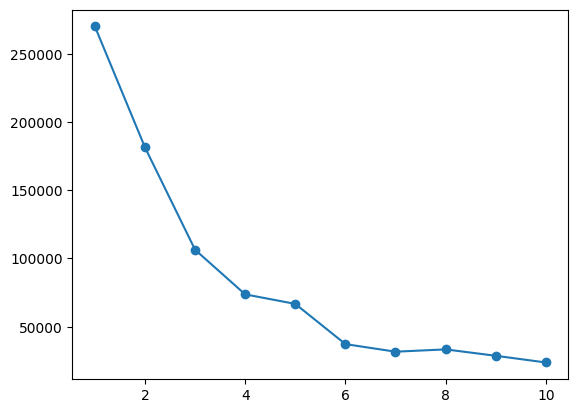

In [49]:
plt.plot(range(1, 11),inertias,marker='o')

Total Iterations: 8


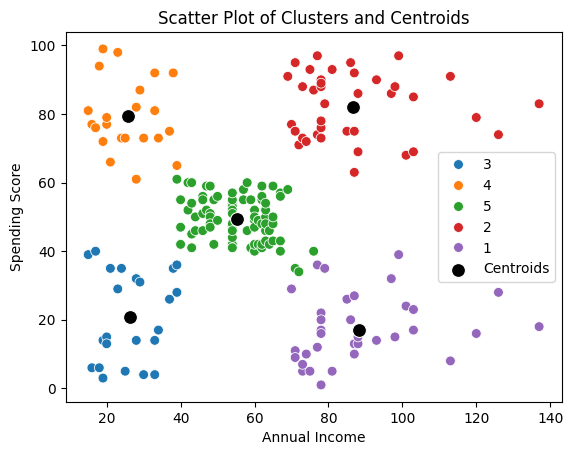

In [50]:
clusters,inertia=k_means(customers,5,n=100)

# **4. K-Means with Scikit-Learn and Interpreting Results**


In [ ]:

cols_to_keep = ['Annual Income', 'Spending Score']

from sklearn.cluster import KMeans

customers = pd.read_csv('mall_customers.csv')

model = KMeans(n_clusters=5)
clusters = model.fit_predict(customers[cols_to_keep])
print(clusters)
print(model.inertia_)
print(model.cluster_centers_)
print(model.n_iter_)
print(model.n_features_in_)
print(model.feature_names_in_)


[2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2
 3 2 3 2 3 2 1 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 4 0 4 1 4 0 4 0 4 1 4 0 4 0 4 0 4 0 4 1 4 0 4 0 4
 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4 0
 4 0 4 0 4 0 4 0 4 0 4 0 4 0 4]
44448.45544793371
[[88.2        17.11428571]
 [55.2962963  49.51851852]
 [26.30434783 20.91304348]
 [25.72727273 79.36363636]
 [86.53846154 82.12820513]]
13
2
['Annual Income' 'Spending Score']


,CustomerID,Gender,Age,Annual Income,Spending Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


## **The Elbow Rule with Scikit-Learn**

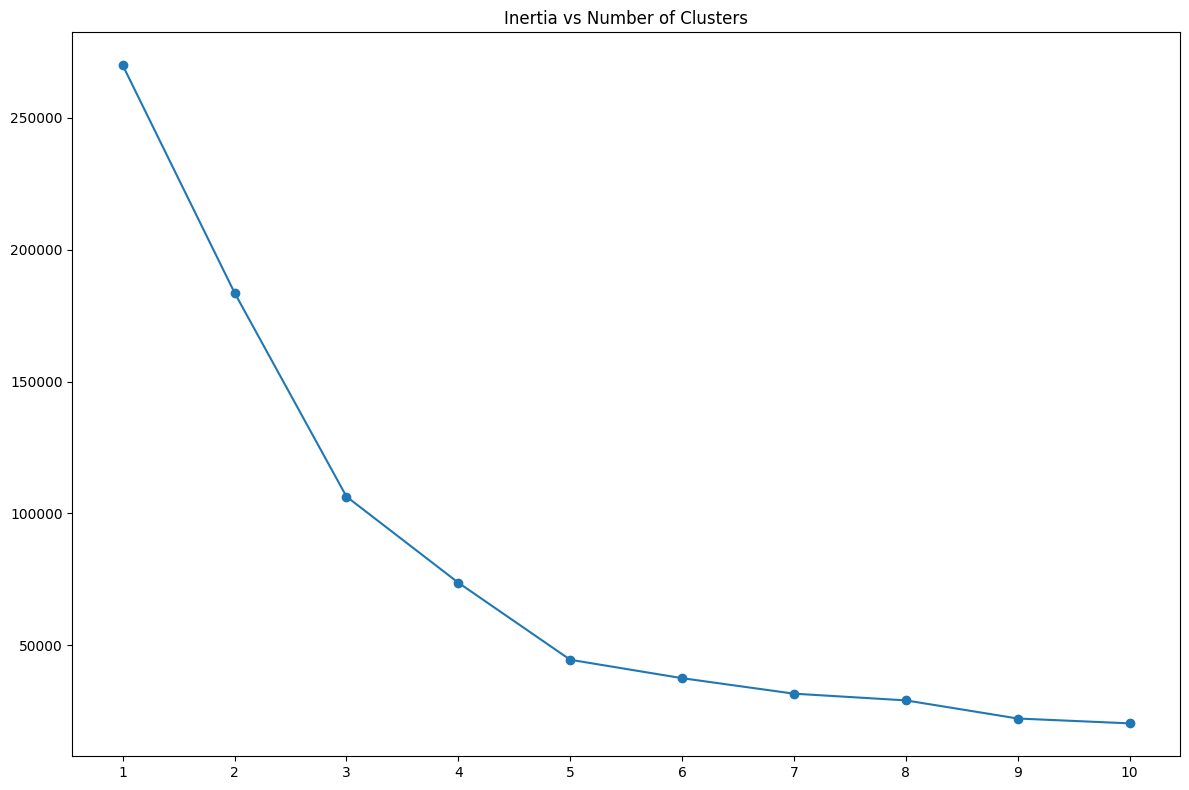

[269981.28, 183653.3289473684, 106348.37306211119, 73679.78903948836, 44448.45544793371, 37455.984555160285, 31577.726355851442, 29032.75552567587, 22155.149490364707, 20313.42789044827]


In [52]:
cols_to_keep = ['Annual Income', 'Spending Score']


def plot_elbow_curve(df, max_clusters=10):
    inertias = []

    for k in range(1, max_clusters+1):
        model = KMeans(n_clusters=k)
        cluster = model.fit_predict(df)
        inertias.append(model.inertia_)
        
    plt.figure(figsize=(12, 8))
    plt.plot(range(1, max_clusters+1), inertias, marker='o')
    plt.xticks(ticks=range(1, max_clusters+1), labels=range(1, max_clusters+1))
    plt.title('Inertia vs Number of Clusters')

    plt.tight_layout()
    plt.show()
    
    return inertias
  

inertias = plot_elbow_curve(customers[cols_to_keep])
print(inertias)

## **Scaling the Data**

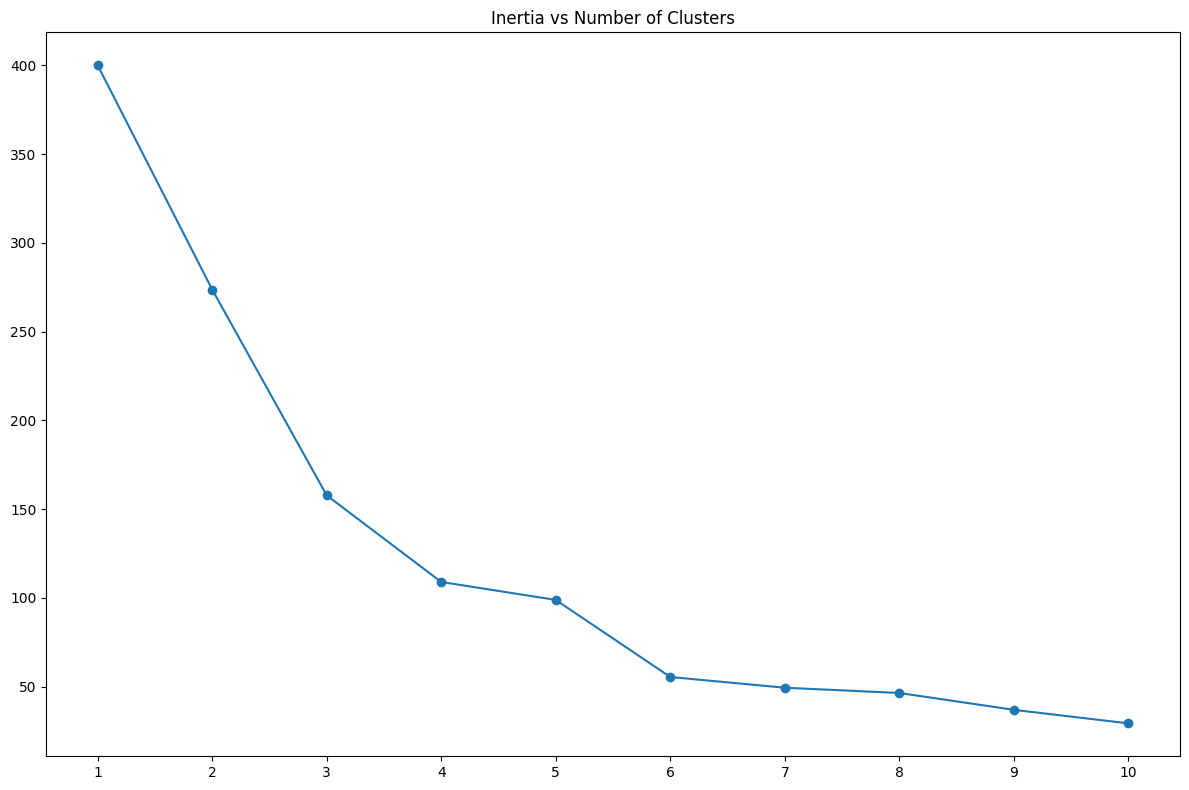

[400.0, 273.6688866264201, 157.70400815035947, 108.92131661364355, 98.80769272556533, 55.37734615765335, 49.35060492333072, 46.37714971845712, 36.89387194054674, 29.26994752156501]


array([[-1.73899919, -0.43480148],
       [-1.73899919,  1.19570407],
       [-1.70082976, -1.71591298],
       [-1.70082976,  1.04041783],
       [-1.66266033, -0.39597992],
       [-1.66266033,  1.00159627],
       [-1.62449091, -1.71591298],
       [-1.62449091,  1.70038436],
       [-1.58632148, -1.83237767],
       [-1.58632148,  0.84631002],
       [-1.58632148, -1.4053405 ],
       [-1.58632148,  1.89449216],
       [-1.54815205, -1.36651894],
       [-1.54815205,  1.04041783],
       [-1.54815205, -1.44416206],
       [-1.54815205,  1.11806095],
       [-1.50998262, -0.59008772],
       [-1.50998262,  0.61338066],
       [-1.43364376, -0.82301709],
       [-1.43364376,  1.8556706 ],
       [-1.39547433, -0.59008772],
       [-1.39547433,  0.88513158],
       [-1.3573049 , -1.75473454],
       [-1.3573049 ,  0.88513158],
       [-1.24279661, -1.4053405 ],
       [-1.24279661,  1.23452563],
       [-1.24279661, -0.7065524 ],
       [-1.24279661,  0.41927286],
       [-1.20462718,

In [53]:
from sklearn.preprocessing import StandardScaler


cols_to_keep = ['Annual Income', 'Spending Score']


def scaler(df):
    scaler = StandardScaler()
    scaler.fit(df)

    df_scaled = scaler.transform(df)
    return df_scaled


scaled_customers = scaler(customers[cols_to_keep])
inertias = plot_elbow_curve(scaled_customers)

print(inertias)
scaled_customers


## **Multivariate K-Means**

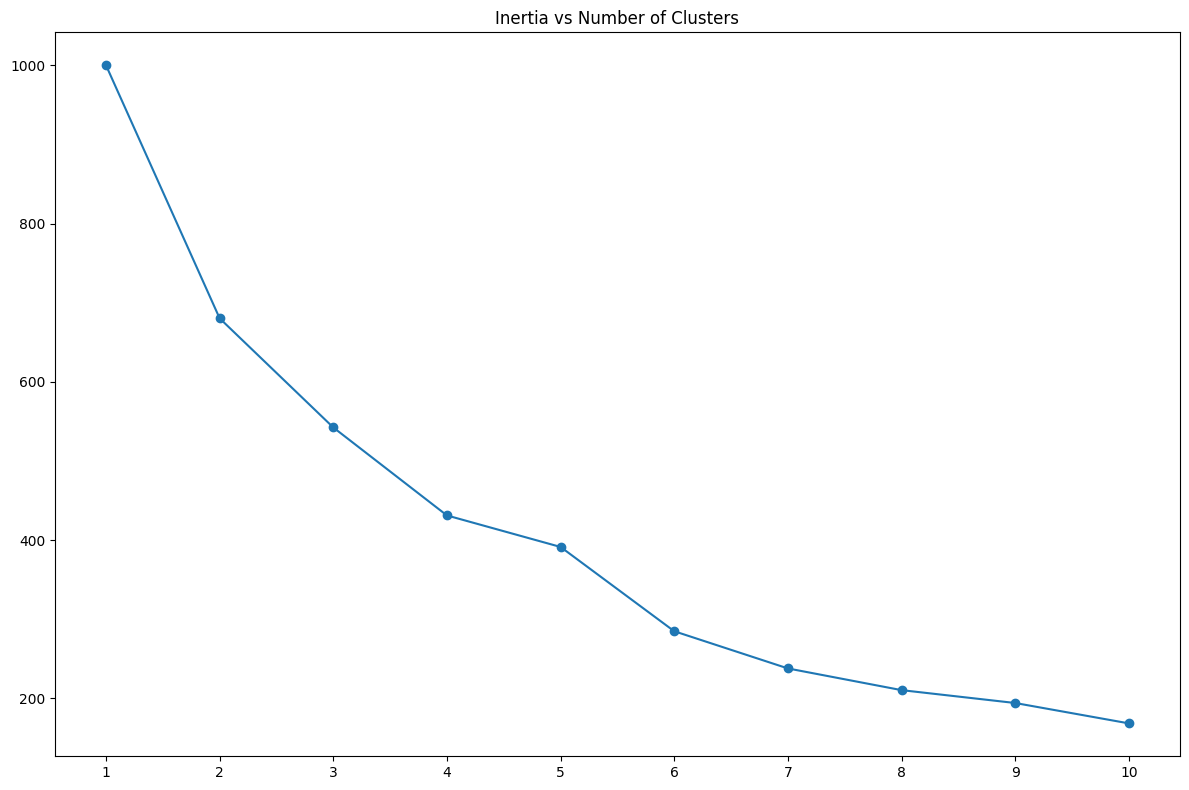

,Gender,Age,Annual Income,Spending Score,Cluster
0,1,19,15,39,4
1,1,21,15,81,4
2,0,20,16,6,2
3,0,23,16,77,1
4,0,31,17,40,2
...,...,...,...,...,...
195,0,35,120,79,1
196,0,45,126,28,5
197,1,32,126,74,6
198,1,32,137,18,5


In [ ]:
customers_modif = customers.copy()
customers_modif.drop('CustomerID', axis=1, inplace=True)
customers_modif['Gender'] = customers_modif['Gender'].map({'Male': 1, 'Female': 0})

scaled_customers = scaler(customers_modif)
plot_elbow_curve(scaled_customers)



## **Multivariate K-Means**

In [ ]:
model = KMeans(n_clusters = 6)
cluster = model.fit_predict(scaled_customers)
customers["Cluster"]=cluster + 1  

print(customers['Cluster'].value_counts())



Cluster
1    58
4    44
2    33
3    25
5    22
6    18
Name: count, dtype: int64


,CustomerID,Gender,Age,Annual Income,Spending Score,Cluster
0,1,Male,19,15,39,3
1,2,Male,21,15,81,3
2,3,Female,20,16,6,4
3,4,Female,23,16,77,4
4,5,Female,31,17,40,4
...,...,...,...,...,...,...
195,196,Female,35,120,79,5
196,197,Female,45,126,28,2
197,198,Male,32,126,74,6
198,199,Male,32,137,18,2


## **Interpreting Results — Numerical Variables**

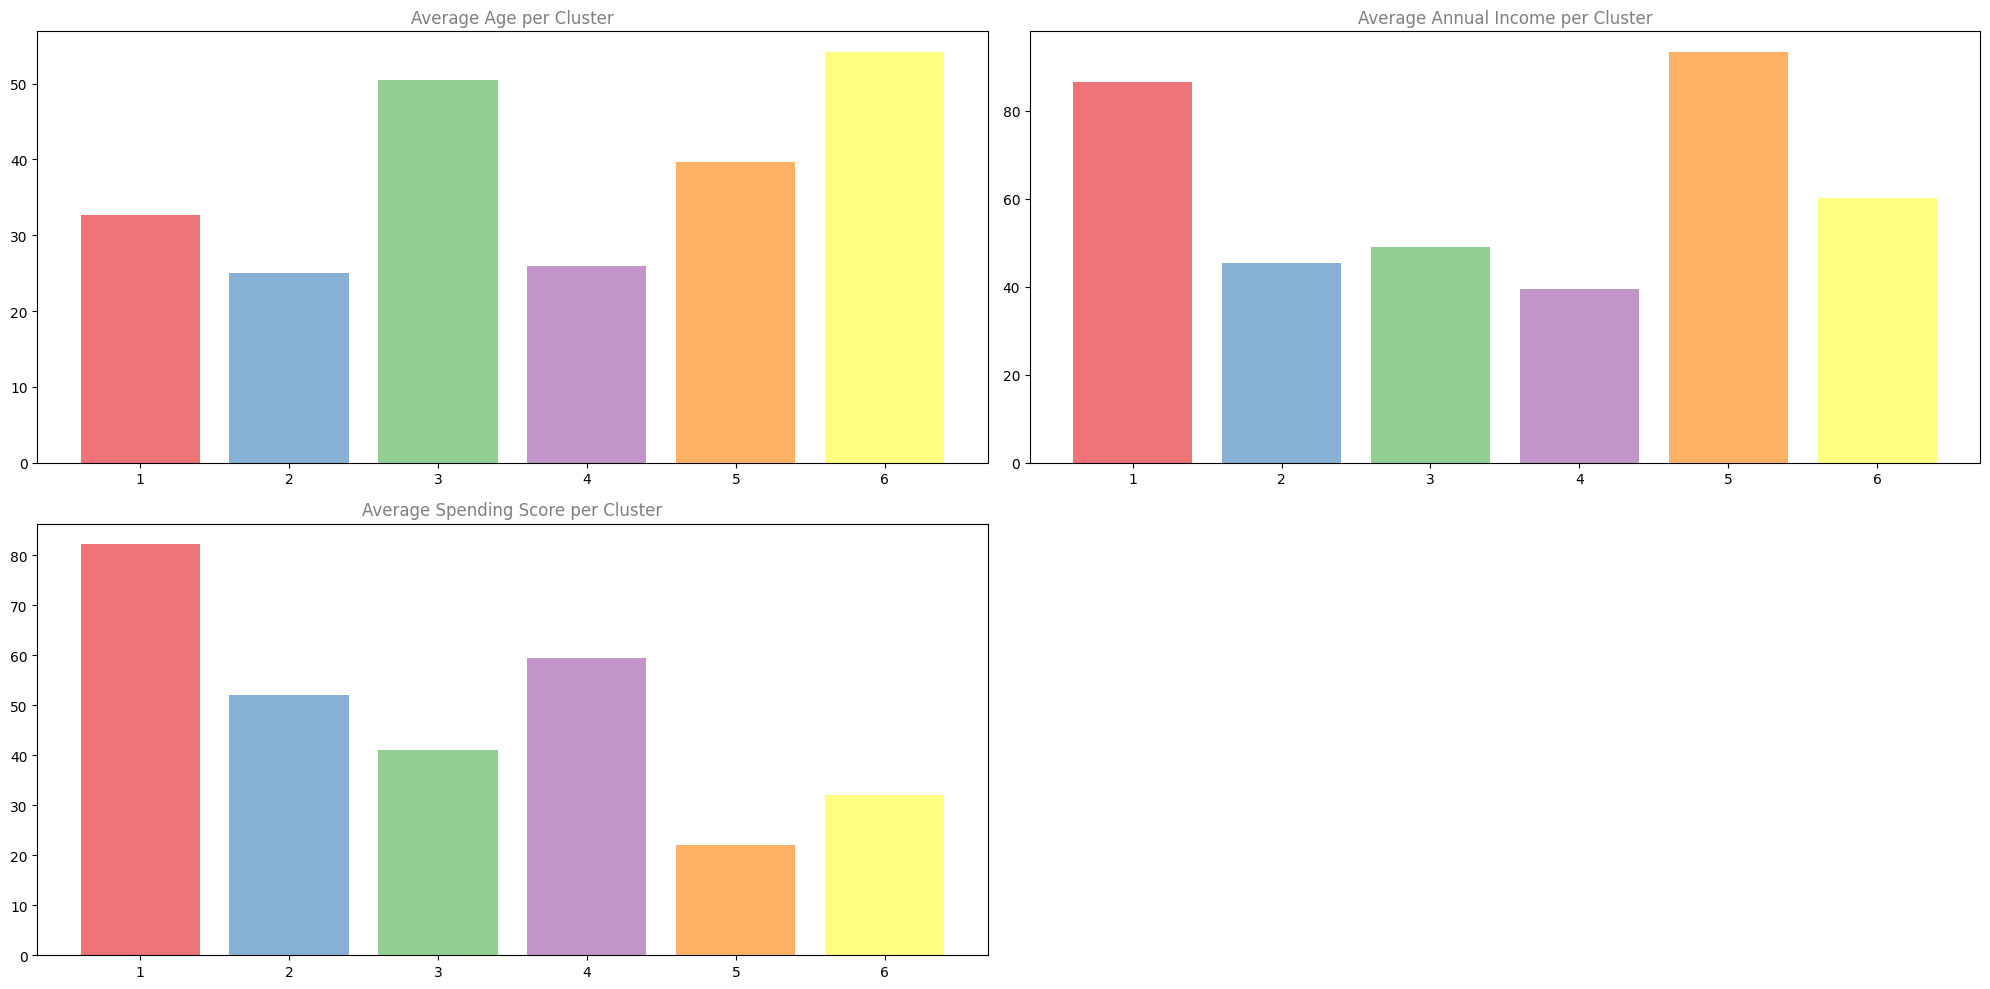

In [ ]:
numeric_columns = ['Age', 'Annual Income', 'Spending Score']


fig = plt.figure(figsize=(20, 10))
for i, column in enumerate(numeric_columns):
    df_plot = customers.groupby('Cluster')[column].mean()    
    ax = fig.add_subplot(2, 2, i+1)
    ax.bar(df_plot.index, df_plot, color=sns.color_palette('Set1'), alpha=0.6)
    ax.set_title(f'Average {column.title()} per Cluster', alpha=0.5)
    ax.xaxis.grid(False)
    
plt.tight_layout()
plt.show()


## **Interpreting Results — Numerical Variables, Part 2**

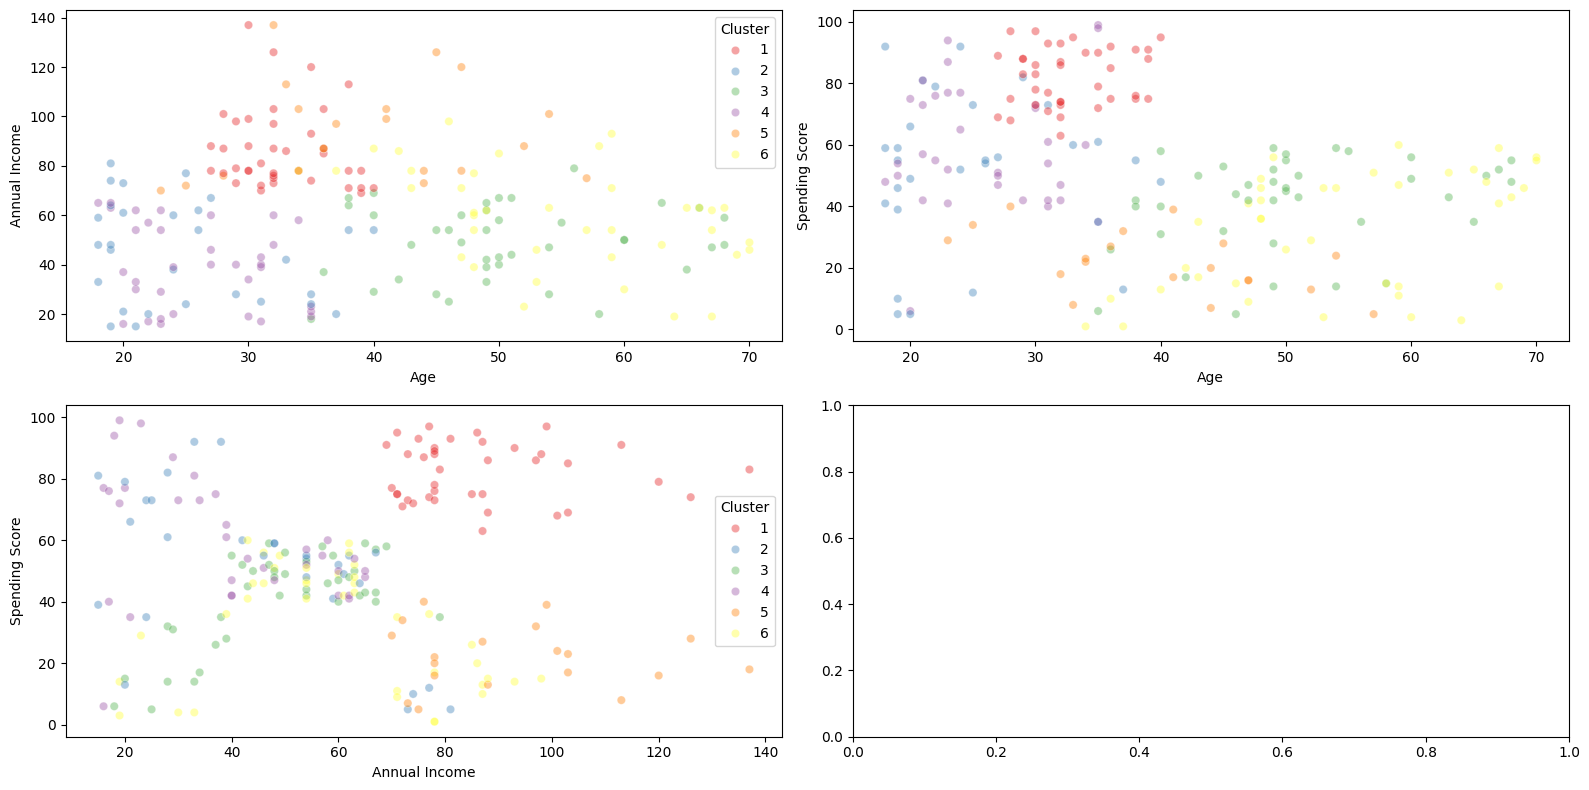

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(16, 8))
sns.scatterplot(x='Age', y='Annual Income', hue='Cluster', data=customers, palette='Set1', alpha=0.4, ax=axs[0][0])

sns.scatterplot(x='Age', y='Spending Score', hue='Cluster', data=customers, palette='Set1', alpha=0.4, ax=axs[0][1], legend=False)

sns.scatterplot(x='Annual Income', y='Spending Score', hue='Cluster', data=customers, palette='Set1', alpha=0.4, ax=axs[1][0])

plt.tight_layout()
plt.show()


## **Interpreting Results — Categorical Variables**

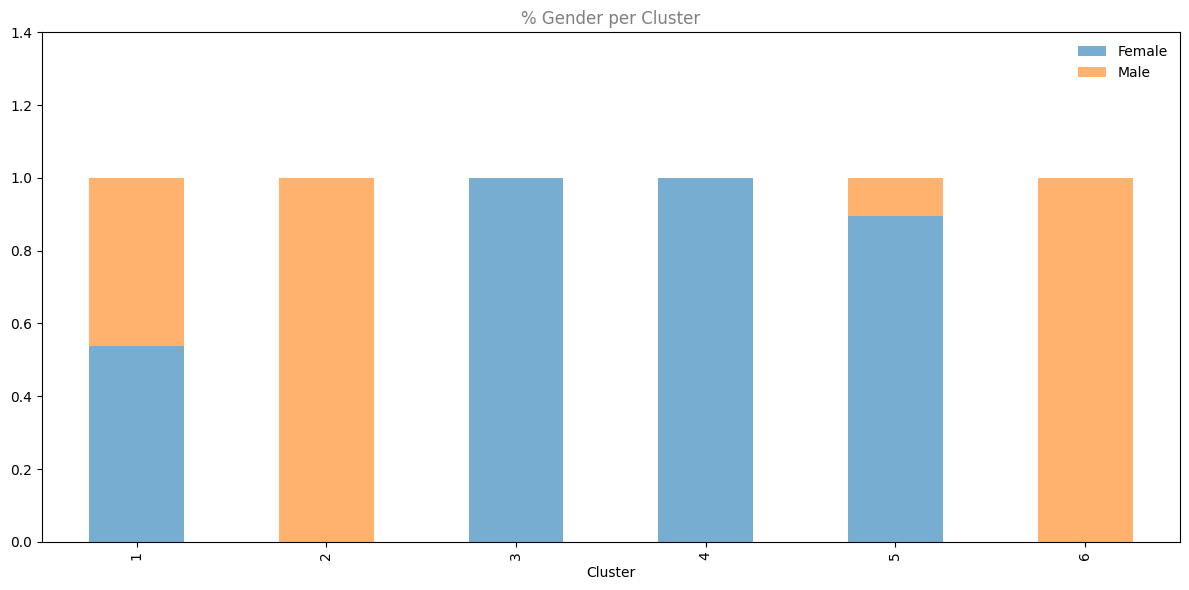

In [58]:
plot_df = pd.crosstab(
  index=customers['Cluster'], columns=customers['Gender'],
  values=customers['Gender'], aggfunc='size', normalize='index'
)
plot_df

fig, ax = plt.subplots(figsize=(12,6))
plot_df.plot.bar(stacked=True, ax=ax, alpha=0.6)
ax.set_title(f'% Gender per Cluster', alpha=0.5)

ax.set_ylim(0, 1.4)
ax.legend(frameon=False)
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()